In [141]:
import pathlib
import camelot
import os
import pickle
import asyncio
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [134]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'

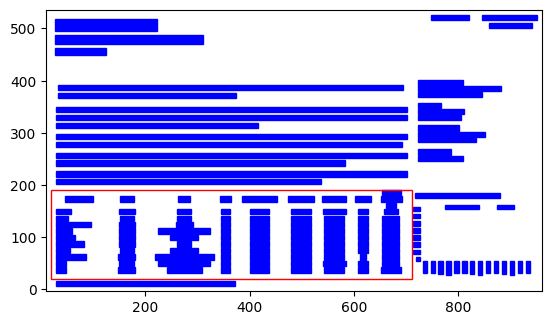

In [135]:
# Testing different values for table_areas
filepath = RAW_DATA_DIR / '2021-12.pdf'
table_areas = ['20,190,710,20']
tables = camelot.read_pdf(str(filepath), flavor='stream', edge_tol=500, table_areas = table_areas)
camelot.plot(tables[0], kind='contour')
plt.show()

In [136]:
print(tables[0].parsing_report)
print(tables[0].shape)
tables[0].df

{'accuracy': 100.0, 'whitespace': 13.68, 'order': 1, 'page': 1}
(13, 9)


,0,1,2,3,4,5,6,7,8
0,,,,,,,,,Valor de
1,Companhia,Ticker,Setor,Peso,Recomendação,Preço atual,Preço-alvo,Upside,mercado
2,,,,,,,,,(Mn)
3,Arezzo,ARZZ3,Varejo,10%,Compra,"R$ 68,20","R$ 108,00",58%,"R$ 6,8"
4,Assaí,ASAI3,Varejo,10%,Compra,"R$ 13,05","R$ 23,00",76%,"R$ 17,6"
5,Banco do Brasil,BBAS3,Bancos,10%,Compra,"R$ 30,81","R$ 52,00",69%,"R$ 87,9"
6,Gerdau,GGBR4,Mineração e Siderurgia,10%,Compra,"R$ 25,80","R$ 32,00",24%,"R$ 44,0"
7,Localiza,RENT3,Transportes,10%,Compra,"R$ 52,25","R$ 68,00",30%,"R$ 39,6"
8,RaiaDrogasil,RADL3,Varejo,10%,Compra,"R$ 22,61","R$ 27,00",19%,"R$ 37,4"
9,Rumo,RAIL3,Transportes,10%,Compra,"R$ 17,62","R$ 24,00",36%,"R$ 32,7"


In [164]:
def extract_table(filepath: pathlib.Path) -> pd.DataFrame:
    table_areas = ['20,190,710,20']
    tables = camelot.read_pdf(str(filepath), flavor='stream', edge_tol=500, table_areas = table_areas)
    if len(tables) == 0:
        raise ValueError(f"No tables found in {filepath}")
    table = tables[0]
    accuracy = table.parsing_report['accuracy']
    if accuracy < 100:
        print(f"Accuracy of table extraction of {filepath} is {accuracy}%")
    df = table.df
    print(filepath)
    camelot.plot(tables[0], kind='contour')

    # Get only 10 last rows
    df = df.iloc[-10:]
    
    if (df.shape[1] != 8 and df.shape[1] != 9):
        raise ValueError(f"Table in {filepath} has wrong number of columns ({df.shape[1]})")
    
    # print (df)
    return df

In [165]:
files = sorted(os.listdir(RAW_DATA_DIR))
print(files)
data = dict()
for i in range(14):
    try:
        df = extract_table(files[i])
        data[files[i]] = df
    except Exception as e:
        print(f"Error: {e}")
        continue

['2021-11.pdf', '2021-12.pdf', '2022-01.pdf', '2022-02.pdf', '2022-03.pdf', '2022-04.pdf', '2022-05.pdf', '2022-06.pdf', '2022-07.pdf', '2022-08.pdf', '2022-09.pdf', '2022-10.pdf', '2022-11.pdf', '2022-12.pdf', '2023-01.pdf', '2023-02.pdf', '2023-03.pdf', '2023-04.pdf', '2023-05.pdf', '2023-06.pdf', '2023-07.pdf', '2023-08.pdf', '2023-09.pdf', '2023-10.pdf', '2023-11.pdf', '2023-12.pdf', '2024-01.pdf', '2024-02.pdf', '2024-03.pdf', '2024-04.pdf', '2024-05.pdf']
Error: [Errno 2] No such file or directory: '2021-11.pdf'
Error: [Errno 2] No such file or directory: '2021-12.pdf'
Error: [Errno 2] No such file or directory: '2022-01.pdf'
Error: [Errno 2] No such file or directory: '2022-02.pdf'
Error: [Errno 2] No such file or directory: '2022-03.pdf'
Error: [Errno 2] No such file or directory: '2022-04.pdf'
Error: [Errno 2] No such file or directory: '2022-05.pdf'
Error: [Errno 2] No such file or directory: '2022-06.pdf'
Error: [Errno 2] No such file or directory: '2022-07.pdf'
Error: [Errn